## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This quantum hybrid approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions, specifically a GHZ state.

This implementation uses aer_simulator_statevector.

## Implementation (statevector simulation)

In [ ]:
# Create enviroment with conda
#conda create -n myenv python=3.10
# IMPORTANT: Make sure you are on 3.10
%pip install qiskit==1.4.3 qiskit-ibm-runtime qiskit-aer qiskit-machine-learning 'qiskit-machine-learning[sparse]' qiskit-algorithms
%pip install torch
%pip install matplotlib
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [41]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal, RealAmplitudes, EfficientSU2, ZZFeatureMap
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import EstimatorQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit.primitives import StatevectorEstimator
from qiskit.visualization import plot_histogram
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

import numpy as np
from torch.optim import Adam
import copy
import matplotlib.pyplot as plt
import time
import os

In [ ]:
# Number of qubits
REAL_DIST_NQUBITS = 8

draw_circuits = 0

draw_prob = 0
draw_images = 0

In [43]:
# Create real data cirdcuit
def generate_ghz(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
 
    l = int(np.ceil(np.log2(num_qubits)))
    for m in range(l, 0, -1):
        for k in range(0, num_qubits, 2 ** m):
            if k + 2 ** (m - 1) >= num_qubits: continue
            qc.cx(k, k + 2 ** (m - 1))
    return qc

real_circuit = generate_ghz(REAL_DIST_NQUBITS)

if draw_circuits:
    real_circuit.draw('mpl')

In [44]:
# Data base (angle embedding required)
X = np.array([
    [
        [1, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 1],
        [0, 1, 1, 0]
    ], 
    [
        [1, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 1],
        [0, 1, 1, 0]
    ]
    ])

# Rescale to [0, π] (important for trigonometric rotation gates)
X_scaled = np.pi * X / np.max(X)

# Define the feature map
feature_map = ZZFeatureMap(feature_dimension=len(X[0].flatten()), reps=1)

# For each sample, bind values into the circuit
from qiskit import transpile

encoded_circuits = []
for x in X_scaled:
    x = x.flatten()
    bound_circuit = feature_map.assign_parameters(x)
    encoded_circuits.append(bound_circuit.decompose())
if draw_circuits:   
    encoded_circuits[0].draw('mpl')


In [45]:
# Create real data sample circuit
def generate_real_circuit(matrix):
    vec = matrix.flatten()
    normed = vec / np.linalg.norm(vec)

    sv = Statevector(normed)
    if not sv.is_valid(): raise Exception("Invalid statevector")

    qc = QuantumCircuit(REAL_DIST_NQUBITS)
    qc.initialize(normed, qc.qubits)
    return qc, sv
    

X = np.array([
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 1, 1, 1],
        [1, 1, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1, 1],
        [1, 1, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0.5, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0.5, 0, 1],
        [1, 0, 0.5, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0.5, 0, 1],
        [1, 0, 0.5, 0.5, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0.5, 0.5, 0, 1],
        [1, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1],
        [1, 0, 0.5, 0.5, 0.5, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1],
        [1, 1, 0, 0.5, 0.5, 0.5, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 1],
        [1, 1, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1, 1],
        [1, 1, 1, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ], 
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ]
    ])

#matrix = X[0]

X = np.array([
    [
        [0, 1, 1, 0],
        [1, 0, 0, 1],
        [1, 0, 0, 1],
        [0, 1, 1, 0]
    ], 
    [
        [1, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 1],
        [0, 1, 1, 0]
    ]
    ])

# matrix = X[0]

# real_circuit, real_prob_sv = generate_real_circuit(matrix)

if draw_images:
    plt.imshow(matrix, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    
    real_prob_list = real_prob_sv.probabilities()
    real_prob_matr = np.array(real_prob_list).reshape((2**int(REAL_DIST_NQUBITS/2), 2**int(REAL_DIST_NQUBITS/2)))
    plt.imshow(real_prob_matr, cmap='gray', vmin=np.min(real_prob_list), vmax=np.max(real_prob_list))
    plt.axis('off')
    plt.show()

In [46]:
# Create generator

# generator = TwoLocal(REAL_DIST_NQUBITS,
#                      # Parameterized single qubit rotations
#                      ['ry', 'rz'],
#                      'cz',  # Entangling gate
#                      'full', # Entanglement structure: all to all
#                      reps=2, # Number of layers
#                      parameter_prefix='θ_g',
#                      name='Generator')

generator = RealAmplitudes(REAL_DIST_NQUBITS,
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() # decompose into standard gates

if draw_circuits:
    generator.draw('mpl')

In [ ]:
# Create discriminator
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [ ]:
# Parameters
N_GPARAMS = generator.num_parameters
N_GPARAMS

(24, 27)

In [ ]:
# Cost calculation functions
def adversarial_loss(input, target):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    total_loss = -torch.sum(bce_loss)
    return total_loss

In [52]:
# Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions

def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [ ]:
# Use EstimatorQNN to compile the parameterized circuit and handle calculation of the gradient recipes.

estimator = StatevectorEstimator()

gradient = ParamShiftEstimatorGradient(estimator=estimator)

# specify QNN to update generator weights
gen_qnn = EstimatorQNN(circuit=generator,  # parameterized circuit
                     # frozen input arguements (discriminator weights)
                     input_params=[],
                     # differentiable weights (generator weights)
                     weight_params=generator.parameters[N_DPARAMS:],
                     estimator=estimator,
                     #gradient=gradient
                     )

# specify QNNs to update discriminator weights regarding to fake data
disc_fake_qnn = EstimatorQNN(circuit=gen_disc_circuit, # parameterized circuit
                           # frozen input arguments (generator weights)
                           input_params=gen_disc_circuit.parameters[N_DPARAMS:],
                           # differentiable weights (discrim. weights)
                           weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                           estimator=estimator,
                           #gradient=gradient
                           )

# # specify QNNs to update discriminator weights regarding to real data
disc_real_qnn = EstimatorQNN(circuit=real_disc_circuit, # parameterized circuit
                           input_params=[], # no input parameters
                           # differentiable weights (discrim. weights)
                           weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                           estimator=estimator,
                           #gradient=gradient
                           )

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [54]:
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))

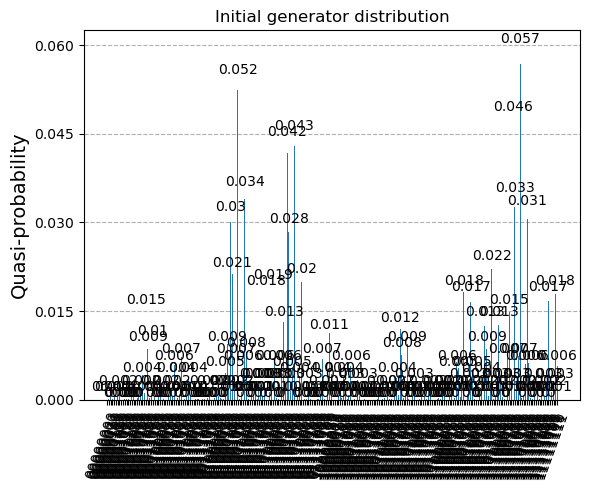

In [55]:
# Display initial generator distribution
init_gen_circuit = generator.assign_parameters(init_gen_params)
init_prob_sv = Statevector(init_gen_circuit)

if draw_prob:
    init_prob_dict = init_prob_sv.probabilities_dict()
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial generator distribution")
    plot_histogram(init_prob_dict, ax=ax1)

if draw_images:
    init_prob_list = init_prob_sv.probabilities()
    init_prob_matr = np.array(init_prob_list).reshape((2**int(REAL_DIST_NQUBITS/2), 2**int(REAL_DIST_NQUBITS/2)))
    plt.imshow(init_prob_matr, cmap='gray', vmin=np.min(init_prob_list), vmax=np.max(init_prob_list))
    plt.axis('off')
    plt.show()


In [56]:
from qiskit_machine_learning.connectors import TorchConnector
import torch
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

gen_params = algorithm_globals.random.random(N_GPARAMS)
disc_params = algorithm_globals.random.random(N_DPARAMS)

gen_qnn = TorchConnector(gen_qnn, gen_params)
disc_fake_qnn = TorchConnector(disc_fake_qnn, disc_params)
disc_real_qnn = TorchConnector(disc_real_qnn, disc_params)

In [57]:
# Initialize Adam optimizer from torch

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(
    gen_qnn.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
    )

discriminator_optimizer = Adam(
    disc_fake_qnn.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

In [ ]:
gen_qnn(torch.tensor(disc_params))

tensor([0.3398], grad_fn=<_TorchNNFunctionBackward>)

In [ ]:
def initialize_parameters(reset, data_folder_name="data", training_data_file_name='training_data_hr', parameter_data_file_name='parameters_hr'):
    data_folder_name += '/'
    if not os.path.exists(data_folder_name):
        os.mkdir(data_folder_name) # Create data folder

    training_data_file = data_folder_name + training_data_file_name + '_q' + str(REAL_DIST_NQUBITS) + '.txt'
    parameter_data_file = data_folder_name + parameter_data_file_name + '_q' + str(REAL_DIST_NQUBITS) + '.txt'

    if reset == 1:
        current_epoch = 0
        gloss, dloss, kl_div = [], [], []

        gen_params = torch.tensor(init_gen_params)
        disc_params = torch.tensor(init_disc_params)
        best_gen_params = torch.tensor(init_gen_params)

        file = open(training_data_file,'w')

    else:
        try:
            with open(training_data_file) as f: # Load training data
                lines = f.read().splitlines()
        except FileNotFoundError:
            print("Training data file not found. Resetting parameters.")
            return initialize_parameters(1, data_folder_name, training_data_file_name, parameter_data_file_name)
        current_epoch = len(lines)
        gloss, dloss, kl_div = [], [], []
        for line in lines:
            line_data = line.split(";")
            if len(line_data) != 4:
                print("Error in training_data.txt file in line:", line)
            gloss.append(np.float64(line_data[1]))
            dloss.append(np.float64(line_data[2]))
            kl_div.append(np.float64(line_data[3]))

        try:
            with open(parameter_data_file) as f: # Load parameters
                line = f.readline()
        except FileNotFoundError:
            print("ERROR: Parameter data file not found, even though training data file exists.")
        line_data = line.split(";")
        if len(line_data) != 3:
            print("Error in parameters.txt file")
        gen_params = tf.Variable(np.array(eval(line_data[0])).astype(float))
        disc_params = tf.Variable(np.array(eval(line_data[1])).astype(float))
        best_gen_params = tf.Variable(np.array(eval(line_data[2])).astype(float))

        file = open(training_data_file,'a')

    return current_epoch, gloss, dloss, kl_div, gen_params, disc_params, best_gen_params, file, parameter_data_file

In [ ]:
# Training

#--- Initialize parameters ---#
max_epoch = 11
reset = 1 # Reset data

current_epoch, gloss, dloss, kl_div, gen_params, disc_params, best_gen_params, file, parameter_data_file = initialize_parameters(reset)


#--- Restor optimizer states ---#


    

TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
print(TABLE_HEADERS)
start_time = time.time()

#--- Training loop ---#
try: # In case of interruption
    for epoch in range(current_epoch, max_epoch):

        #--- Quantum discriminator parameter updates ---#
        D_STEPS = 2 # N discriminator updates per generator update
        for disc_train_step in range(D_STEPS):
            fake_disc_value = disc_fake_qnn(torch.tensor(gen_params))

            discriminator_optimizer.zero_grad()
            generator_loss = adversarial_loss(disc_value, valid, gen_dist)

            # store for plotting
            generator_loss_values.append(generator_loss.detach().item())

            generator_loss.backward(retain_graph=True)
            generator_optimizer.step()

            # Train Discriminator
            discriminator_optimizer.zero_grad()

            real_loss = adversarial_loss(disc_value, valid, real_dist)
            fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
            discriminator_loss = (real_loss + fake_loss) / 2

            # Store for plotting
            discriminator_loss_values.append(discriminator_loss.detach().item())

            discriminator_loss.backward()
            discriminator_optimizer.step()

            entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
            entropy_values.append(entropy_value)
            grad_dcost_fake = disc_fake_qnn.backward(gen_params, disc_params)[1][0,0]
            grad_dcost_real = disc_real_qnn.backward([], disc_params)[1][0,0]
            grad_dcost = grad_dcost_real - grad_dcost_fake
            grad_dcost = torch.tensor(grad_dcost)
            
            discriminator_optimizer.apply_gradients(zip([grad_dcost], [disc_params]))
            
            if disc_train_step % D_STEPS == 0:
                dloss.append(discriminator_cost(disc_params))

        #--- Quantum generator parameter updates ---#
        for gen_train_step in range(1):
            grad_gcost = gen_qnn.backward(disc_params, gen_params)[1][0,0]
            grad_gcost = torch.tensor(grad_gcost)

            generator_optimizer.apply_gradients(zip([grad_gcost], [gen_params]))
            gloss.append(generator_cost(gen_params))

        #--- Track KL and save best performing generator weights ---#
        gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy()) # Create test circuit with updated gen parameters
        gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict() # Retrieve probability distribution of current generator
        
        real_prob_dict = Statevector(real_circuit).probabilities_dict() # Constant real probability distribution
        
        current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
        kl_div.append(current_kl)
        if np.min(kl_div) == current_kl:
            best_gen_params = copy.deepcopy(gen_params) # New best

        #--- Save progress in file ---#
        file.write(str(epoch) + ";" + str(gloss[-1]) + ";" + str(dloss[-1]) + ";" + str(kl_div[-1]) + "\n")

        if epoch % 10 == 0: # Print progress
            for header, val in zip(TABLE_HEADERS.split('|'),
                                (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                print(f"{val:.3g} ".rjust(len(header)), end="|")
            start_time = time.time()
            print()
            
#--- Save training data and states ---#
finally:
    file.close()
    file = open(parameter_data_file,'w')
    file.write(str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
    file.close()
    
print("Training complete.")


Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |
   10 |         -0.487 |            -0.0315 |    10.2 |         8.41 | 1.96 |
Training complete.


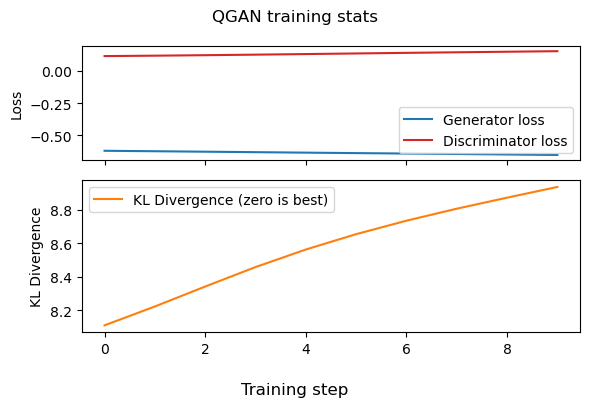

In [ ]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout()

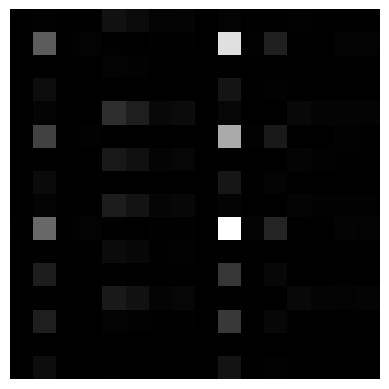

NameError: name 'real_prob_sv' is not defined

In [ ]:
# Create test circuit with new parameters
draw_prob = 0
if draw_prob:
    gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())
    gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,3))
    #fig, ax1 = plt.subplots(1, 1, sharey=True)
    plot_histogram(gen_prob_dict, ax=ax1)
    ax1.set_title("Trained generator distribution")
    plot_histogram(real_prob_dict, ax=ax2)
    ax2.set_title("Real distribution")
    fig.tight_layout()

draw_images = 1
if draw_images:
    gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())
    gen_prob_sv = Statevector(gen_checkpoint_circuit)
    gen_prob_list = gen_prob_sv.probabilities()
    gen_prob_matr = np.array(gen_prob_list).reshape((2**int(REAL_DIST_NQUBITS/2), 2**int(REAL_DIST_NQUBITS/2)))
    plt.imshow(gen_prob_matr, cmap='gray', vmin=np.min(gen_prob_list), vmax=np.max(gen_prob_list))
    plt.axis('off')
    plt.show()

    real_prob_list = real_prob_sv.probabilities()
    real_prob_matr = np.array(real_prob_list).reshape((2**int(REAL_DIST_NQUBITS/2), 2**int(REAL_DIST_NQUBITS/2)))
    plt.imshow(real_prob_matr, cmap='gray', vmin=np.min(real_prob_list), vmax=np.max(real_prob_list))
    plt.axis('off')
    plt.show()